# Preparing the Environment

In [ ]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import json
import re

from collections import Counter
from tqdm.notebook import tqdm
from typing import *

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# pythorch imports
import torch

from torch import nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
# seed used in order to thave reproducibility
SEED = 93

# patience in the train
PATIENCE = 10

# weight to give to the target term when building the embeddings of the phrases
# I have set it to zero since I think that is more important the context than
# the given term, since it is surely in both the phrases
WEIGHT = 0

# embedding dimension
EMBEDDING_DIMENSION = 300


LR = 0.000_01
BATCH_SIZE = 300

In [ ]:
# hanlde preproducibility by setting the seed and deterministic algorithms
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

In [ ]:
# get the name of the file (works in colab) I sued it in order to save the 
# models (since I tried several models each with a different colab file)
from requests import get
# the below command do not work in local, but works in colab
#FILE_NAME = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
FILE_NAME = "NLP-HW1-First-Method-New-Dataset"

In [ ]:
! rm -rf sample_data

In [ ]:
# download the datasets
! wget https://pilehvar.github.io/xlwic/data/xlwic_datasets.zip

--2021-05-01 09:36:48--  https://pilehvar.github.io/xlwic/data/xlwic_datasets.zip
Resolving pilehvar.github.io (pilehvar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to pilehvar.github.io (pilehvar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18748158 (18M) [application/zip]
Saving to: ‘xlwic_datasets.zip’

xlwic_datasets.zip  100%[===================>]  17.88M  --.-KB/s    in 0.1s    

2021-05-01 09:36:48 (161 MB/s) - ‘xlwic_datasets.zip’ saved [18748158/18748158]



In [ ]:
! unzip /content/xlwic_datasets.zip

Archive:  /content/xlwic_datasets.zip
   creating: xlwic_datasets/
  inflating: xlwic_datasets/.DS_Store  
  inflating: xlwic_datasets/README.txt  
   creating: xlwic_datasets/wic_english/
  inflating: xlwic_datasets/wic_english/train_en.txt  
  inflating: xlwic_datasets/wic_english/valid_en.txt  
  inflating: xlwic_datasets/xlwic_scorer.py  
   creating: xlwic_datasets/xlwic_wikt/
  inflating: xlwic_datasets/xlwic_wikt/.DS_Store  
   creating: xlwic_datasets/xlwic_wikt/french_fr/
  inflating: xlwic_datasets/xlwic_wikt/french_fr/.DS_Store  
   creating: xlwic_datasets/xlwic_wikt/french_fr/IV/
  inflating: xlwic_datasets/xlwic_wikt/french_fr/IV/fr_iv_test_data.txt  
  inflating: xlwic_datasets/xlwic_wikt/french_fr/IV/fr_iv_test_gold.txt  
   creating: xlwic_datasets/xlwic_wikt/french_fr/OOV/
  inflating: xlwic_datasets/xlwic_wikt/french_fr/OOV/fr_oov_test_data.txt  
  inflating: xlwic_datasets/xlwic_wikt/french_fr/OOV/fr_oov_test_gold.txt  
  inflating: xlwic_datasets/xlwic_wikt/french_

In [ ]:
# load train and dev sets
with open ("/content/xlwic_datasets/wic_english/train_en.txt") as fin:
  data = []
  cnt = 0
  for line in fin:
    elements = line.strip().split('\t')
    
    entry = {
        "lemma" : elements[0],
        "pos" : elements[1],
        "start1" : elements[2],
        "end1" : elements[3], 
        "start2" : elements[4], 
        "end2" : elements[5], 
        "sentence1" : elements[6], 
        "sentence2" : elements[7], 
        "label" : "True" if elements[8] == "1" else "False"
    }
    data.append(entry)


with open ("/content/xlwic_datasets/wic_english/valid_en.txt") as fin:
  for line in fin:
    elements = line.strip().split('\t')
  
    entry = {
        "lemma" : elements[0],
        "pos" : elements[1],
        "start1" : elements[2],
        "end1" : elements[3], 
        "start2" : elements[4], 
        "end2" : elements[5], 
        "sentence1" : elements[6], 
        "sentence2" : elements[7], 
        "label" : "True" if elements[8] == "1" else "False"
    }
    data.append(entry)


In [ ]:
# see the structure of an entry of the dataset
data[0]

{'end1': '8',
 'end2': '11',
 'label': 'False',
 'lemma': 'approach',
 'pos': 'V',
 'sentence1': 'Approach a task.',
 'sentence2': 'To approach the city.',
 'start1': '0',
 'start2': '3'}

**Visualize class distribution** in order to see if is usefull to weight the classes in the loss function

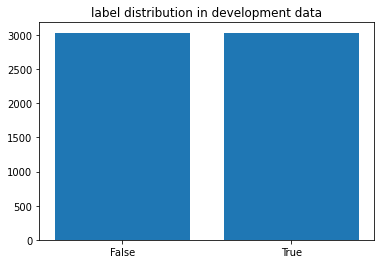

T: 3033
F: 3033


In [ ]:
def visualize_class_distribution(train_gold: dict, title: str):
    
    counter = Counter()

    for entry in train_gold:
        label = entry["label"] 
        counter[label] += 1

    labels = sorted(counter)
    values = [counter[label] for label in labels]

    plt.bar(labels, values)
    plt.title(title)
    plt.show()
    t_count = counter["True"]
    f_count = counter["False"]
    
    print(f"T: {t_count}")
    print(f"F: {f_count}")


visualize_class_distribution(data, "label distribution in development data")


So the classes are balanced. 
Let's see how the classes are distributed with respect to the pos tag


pos: V


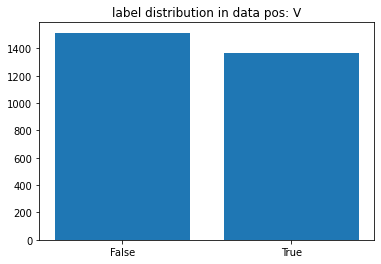

T: 1364
F: 1514

pos: N


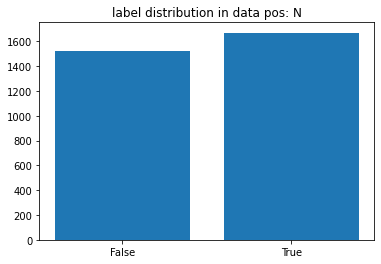

T: 1669
F: 1519


In [ ]:
def visualize_class_distribution_wrt_pos(train: dict, title: str):
    # dictionary containing a counter per pos
    counter = {}  
  
    for entry in train:
        label = entry["label"] 
        pos = entry["pos"]
        if (not pos in counter):
          counter[pos] = Counter()  
        counter[pos][label] += 1

    for pos in counter:
      print(f"\npos: {pos}")
      labels = sorted(counter[pos])
      values = [counter[pos][label] for label in labels]

      plt.bar(labels, values)
      plt.title(title + f" pos: {pos}")
      plt.show()
      t_count = counter[pos]["True"]
      f_count = counter[pos]["False"]
    
      print(f"T: {t_count}")
      print(f"F: {f_count}")

visualize_class_distribution_wrt_pos(data, "label distribution in data")


As we can see from the precedent plots the classes are almost balanced also with respect to the pos tags

In [ ]:
# download the pre trained embeddings
! wget http://nlp.stanford.edu/data/glove.840B.300d.zip

--2021-05-01 09:37:03--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2021-05-01 09:37:03--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2021-05-01 09:37:04--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip

In [ ]:
# unzip the embeddings
! sudo apt-get install unzip
! unzip glove.840B.300d.zip -d glove

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Archive:  glove.840B.300d.zip
  inflating: glove/glove.840B.300d.txt  


In [ ]:
# Split data into train, dev and test
import random
random.seed(SEED)
random.shuffle(data)
train = data[:int(len(data)*0.8)]
dev = data[int(len(data)*0.8):int(len(data)*0.9)]
test = data[int(len(data)*0.9):]


**Load the embedding** and check for oov terms

In [ ]:
# load the embeddings to a dictionary with key the term and value the embedding
embeddings = {}
with open(f"glove/glove.840B.{EMBEDDING_DIMENSION}d.txt") as fin:
  for line in fin:
    term, *embedding = line.strip().split(" ")
    embedding = torch.tensor(list(map(lambda x: float(x), embedding)))
        
    embeddings[term] = embedding

In [ ]:
# check for out of words vocabulary
def check_oovs(train:list, dev:list, test:list, embeddings:dict):
  oovs = {}
  for dataset in [(train, "train"), (dev, "dev"), (test, "test")]:
    oovs[dataset[1]] = set()
    for entry in dataset[0]:
      s1 = entry["sentence1"]
      for term in s1.split(" "):
        if (term not in embeddings):
          oovs[dataset[1]].add(term)
      
      s2 = entry["sentence2"]
      for term in s2.split(" "):
        if (term not in embeddings):
          oovs[dataset[1]].add(term)
    # print num of oov terms
    print(len(oovs[dataset[1]]))
    # print the first oov terms
    print(list(oovs[dataset[1]])[:20])

check_oovs(train, dev, test, embeddings)

2737
['automatically.', 'doughnuts.', 'invention.', 'falling.', 'birdies.', 'thumb.', 'unusual.', 'sermon,', 'claims.', 'salary.', 'orbit.', "James's", 'cigar.', "moon's", 'impressive,', 'squeakers.', 'conversation"', 'coffee,', 'Prescott.', "government's"]
558
['here!', 'invention.', 'painlessly,', 'pheasants.', 'stains.', 'numbers?', "There's", 'shut.', 'economics.', "isn't", 'windows?', 'west.', 'onions.', 'Prescott.', 'triangle.', 'traitor.', 'art!', 'table?', 'agonist.', 'inferior.']
561
['doughnuts.', 'six.', 'here!', 'poet,', 'falling.', 'governor.', 'drill?', 'stains.', 'limitations.', 'unusual.', 'shut.', 'cigar.', 'limitation.', "'will", 'remarks?', 'quick,', "Mann's", 'scissors,', 'division.', 'feared,']


I have to do some preprocessing of the data in order to remove some out of vocabulary terms: 

1. remove punctuation
2. lower 

In [ ]:
# I tried also to remove stopwords but this was not usefull
def remove_stopwords(phrase: str, original_term: str):
  tokens = phrase.split(" ")
  tokens = [token for token in tokens if (token == original_term or not token in stopwords.words()) ]

  return (" ").join(tokens)

# preprocess a single phrase by removing punctuation and lowerize it
def preprocess_phrase(sentence:str, start:int, end:int):
  # get the original target term
  original_term = sentence[start:end].lower()
  
  # replace punctuation with space
  sentence = re.sub(r"[()\",\-—.;/:@<>#?!&$“”'’`–%\[\]−]+", " ", sentence) 
  # remove extra space
  sentence = re.sub(r"\s+", " ", sentence)
  sentence = sentence.replace("'s", " 's")
  # strip and lowerize the obtained sentence
  sentence = sentence.strip().lower()
  
  # get the new position of the target term
  start_n = sentence.find(original_term)
  end_n = start_n + len(original_term)

  # check that the position is correct
  assert original_term == sentence[start_n:end_n] 

  return sentence, start_n, end_n

def preprocessing(entries: List[Dict])-> List[Dict]:
  preprocessed = []
  for entry in entries:
    
    # get preprocessed phrase and the position of the target term
    sentence1, start1, end1 = preprocess_phrase(entry["sentence1"], int(entry["start1"]), int(entry["end1"]))
    sentence2, start2, end2 = preprocess_phrase(entry["sentence2"], int(entry["start2"]), int(entry["end2"]))
    
    # copy the entry and replace senteces and positions of the target terms
    # in both the phrases
    preprocessed_entry = entry.copy()
    preprocessed_entry["sentence1"] = sentence1
    preprocessed_entry["sentence2"] = sentence2
    preprocessed_entry["start1"] = start1
    preprocessed_entry["end1"] = end1
    preprocessed_entry["start2"] = start2
    preprocessed_entry["end2"] = end2
    
    preprocessed.append(preprocessed_entry)

  return preprocessed


train_n, dev_n, test_n = preprocessing(train), preprocessing(dev), preprocessing(test)

check_oovs(train_n, dev_n, test_n, embeddings)

48
['kronas', 'hapsburg', 'vr+', 'rohmer', 'adoxography', 'magnoliophyta', '2*x', '4ac2a', 'grāmata', 'maksā', 'simenon', 'x^2', 'buggywhips', 'decussates', 'påverkar', '\\sqrtb^2', 'acquaitance', '\\mathbbq', 'lysistrata', 'sunjeong']
15
['kronas', 'baddeck', '2*x', 'e^i\\pi+1=0', 'grāmata', 'kurss', 'ulteriority', 'piecas', 'maksā', 'tithonian', 'x^2', 'allowanced', 'nibelung', 'clippurse', '\\pi']
7
['\\mathbbq', 'vr+', 'lysistrata', 'ulteriorities', 'slowcoaches', 'magnoliales', 'ulteriority']


As we can see from the precedent part we have removed a lot of oovs by removing punctuation and applying lower() to the entire phrase

In [ ]:
STOPWORDS = stopwords.words()
# weight used when computing the avg of the embeddings of the phrase for the stopwords
STOPWORDS_WEIGHT = 0.1
# function that associates phrase to phrase embedding given an embedding and the
# target term
def phrase2vector(phrase: str, embeddings: dict, lemma:str):
  # split the phrase into tokens
  terms = phrase.split(" ")
  # start the phrase embedding as a zero tensor
  sum = torch.zeros(EMBEDDING_DIMENSION)

  # n -> num of non zero embeddings
  n = 0
  for term in terms:
    if (term in embeddings ):
      # get the embedding of the term and turn it to tensor
      emb = embeddings[term]
      # update the counter of non zero embeddings
      n += 1
      # update the sum of embeddings of the phrase 
      # the target term is weighted with WEIGHT
      # the stopwords also are weighted with STOPWORDS_WEIGHT
      # the other term have weight = 1
      sum = sum + WEIGHT*emb if term == lemma else (sum + STOPWORDS_WEIGHT*emb if term in STOPWORDS else sum + emb)

    # in order to avoid possible errors in test phase
    # (for train and dev data is not necessary)
    n = 1 if n == 0 else n 
  return sum/n

In [ ]:
class PhraseDataset(Dataset):

    def __init__(self, dataset: list, feature_extraction_function: Callable[[str], torch.tensor], embeddings: dict):
        
        self.embeddings = embeddings
        self.dataset = dataset
        self.feature_extraction_function = feature_extraction_function
        # initialize the data
        self.__init_data()


    def __init_data(self):
        self.samples = []
        for entry in self.dataset:
          # for each entry in the dataset get the target term
          term_1 = entry["sentence1"][entry["start1"]: entry["end1"]]
          term_2 = entry["sentence2"][entry["start2"]: entry["end2"]]

          # get the embeddings of the phrases
          emb_1 = self.feature_extraction_function(entry["sentence1"], self.embeddings, term_1)
          emb_2 = self.feature_extraction_function(entry["sentence2"], self.embeddings, term_2)
          
          # build the data sample as a tuple containing 
          # 1) a tuple with the two embeddings of the sentences
          # 2) the label
          data = ((emb_1, emb_2), float(1) if entry["label"] == "True" else float(0))

          # append the sample
          self.samples.append(data)
          
    def __len__(self):
        # returns the number of samples in our dataset
      return len(self.samples)

    def __getitem__(self, idx):
        # returns the idx-th sample
        return self.samples[idx]

In [ ]:
# create the Dataset objects for train and dev datasets
train_dataset = PhraseDataset(train_n, phrase2vector, embeddings)
dev_dataset = PhraseDataset(dev_n, phrase2vector, embeddings)
test_dataset = PhraseDataset(test_n, phrase2vector, embeddings)


In [ ]:
# create the dataloader objects for train and test with batch size to BATCH_SIZE
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# see the structure of a sample from the dataloader
for batch in train_dataloader:
    
    batch_x, batch_y = batch
    print(f"# batch len: {len(batch_x)}")
    print(f"# batch x[0] shape: \n{batch_x[0].shape}")
    print(f"# batch x[1] shape: \n{batch_x[1].shape}")

    print(f"# batch y shape: \n{batch_y.shape}")
    break

# batch len: 2
# batch x[0] shape: 
torch.Size([300, 300])
# batch x[1] shape: 
torch.Size([300, 300])
# batch y shape: 
torch.Size([300])


# Train

In [ ]:
# method to save the model 
def save_model(model: nn.Module, path:str):
  torch.save(model.state_dict(), path)

In [ ]:
# method to train and evaluate
def train_and_evaluate(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    train_dataloader: DataLoader,
    epochs: int = 50,
    dev_dataloader: DataLoader = None,
    dev_fn: Callable = None,
    verbose: bool = True,
):
    # history
    train_loss = []
    dev_losses = []
    dev_accs = []
    train_accs = []

    # current value of patience
    patience = 0
    for epoch in range(epochs):
        # put the model in train mode so that we activate the dropout
        model.train()
        # store the losses and the accs over the several batches in this epoch
        losses = []
        accs = []

        # for each batch
        for x, y in train_dataloader:
            # reset the gradient of the optimizer
            optimizer.zero_grad()
            # batch_out is a dictionary with loss and acc keys
            batch_out = model(x[0], x[1], y.float())
            loss = batch_out["loss"]
            acc = batch_out["acc"]
            # store the acc and the loss
            losses.append(loss)
            accs.append(acc)

            # computes the gradient of the loss
            loss.backward()
          
            # updates parameters based on the gradient information
            optimizer.step()

        model.global_epoch += 1
        # mean loss and acc in the epoch
        mean_loss = sum(losses) / len(losses)
        mean_acc = sum(accs) / len(accs)
        
        # store the mean loss and acc
        train_loss.append(mean_loss.item())
        train_accs.append(mean_acc.item())
        
        if verbose or epoch == epochs - 1:
            print(f"\tEpoch\t{model.global_epoch:3d} => Loss: {mean_loss:0.6f}")
        
        if dev_dataloader and dev_fn is not None:
            
            # put the model in evaluating mode
            model.eval()
            # evaluate the model over the development set
            dev_output = dev_fn(model, dev_dataloader)
            # get acc and loss
            dev_loss_value = dev_output["loss"]
            dev_acc_value = dev_output["acc"]
            # if the loss is higher than the minimun dev loss stored, increase 
            # patience level, otherwise reset it 
            if (len(dev_losses) > 0 and dev_loss_value > min(dev_losses)):
              patience += 1
            else:
              # save the best model (it will be overwritten when I arrive to a 
              # lower loss value
              save_model(model, f"{FILE_NAME}.pt")
              patience = 0
            
            # save dev loss and acc
            dev_losses.append(dev_loss_value)
            dev_accs.append(dev_acc_value)

            # info prints
            print(f"\t\tDevelopment => Loss: {dev_loss_value:0.6f}")
            print(f"\t\tDevelopment => Acc: {dev_acc_value:0.6f}")
            print()

            # early stopping
            if (patience > PATIENCE):
              print("EARLY STOPPING")
              break 
    
    return {"train": train_loss, "dev":dev_losses, "dev_accs":dev_accs, "train_accs": train_accs}

In [ ]:
class Classifier(torch.nn.Module):

    def __init__(self, 
                 n_features: int, 
                 n_hidden1: int, 
                 n_hidden2: int, 
                 dropout:float):
        super().__init__()
        # the first linear layer is shared among the emebeddings of the two sentences
        self.lin1 = torch.nn.Linear(n_features, n_hidden1)
        # second lienar layer
        self.lin2 = torch.nn.Linear(n_hidden1, n_hidden2)
        # third one that creates the output
        self.lin3 = torch.nn.Linear(n_hidden2, 1)
        # dropout
        self.drop = torch.nn.Dropout(dropout)
        # batch normalization
        self.bn1 = nn.BatchNorm1d(num_features=n_hidden1)
        self.bn2 = nn.BatchNorm1d(num_features=n_hidden2)

        self.loss_fn = torch.nn.BCELoss()
        self.global_epoch = 0
    def forward(self, ph1: torch.Tensor, ph2: torch.Tensor, y: Optional[torch.Tensor] = None) -> Dict:
        
        # the embeddings of the two phrases pass through the same linear layer
        # so that changing the order does not change the result
        out1 = self.lin1(ph1)
        out1 = torch.relu(out1)
        # I use the batch normalization in order to speed up the learning
        out1 = self.bn1(out1)

        out2 = self.lin1(ph2)
        out2 = torch.relu(out2)
        out2 = self.bn1(out2)


        # element wise product of the two matrices
        # in order to merge the results of the first linear layer
        # of the two sentence embedding
        out = out1*out2    

        # fc layer with dropout
        res = self.lin2(out)
        res = torch.relu(res)
        res = self.drop(res)
        
        res = self.lin3(res)
        # pass results in 0-1 range
        res = torch.sigmoid(res)
        
        # remove a dimension
        res = res.squeeze()

        # save the predictions in order to return it
        result = {"pred": res}

        # compute loss and acc
        if y is not None:
            loss = self.loss(res, y)
            result["loss"] = loss
            result["acc"] = (torch.round(res) == y).float().sum()/len(y)
            result["correct"] = (torch.round(res) == y).float().sum()

        return result

    def loss(self, pred, y):
        return self.loss_fn(pred, y)


In [ ]:
@torch.no_grad()
def evaluate(
    model: nn.Module,
    dataloader: DataLoader,
):
    losses = []
    accs = []
    size = 0
    for x, y in dataloader:
        # get the number of elements in the batch (it is not constant since the 
        # number of examples is not a multiple of BATCH_SIZE, so the last batch
        # will be smaller)
        size += len(y)
        outputs = model(x[0], x[1], y.float())
        # get loss and acc
        loss = outputs["loss"]
        losses.append(loss*len(y))

        # in acc I store the number of correct elements predicted
        # so that I can than sum all the values and obtain the accuracy on the 
        # set by dividing for the number of elements tested  
        accs.append(outputs["correct"])

    # get mean acc and mean loss
    mean_acc = sum(accs)/size
    mean_loss = sum(losses) / size
    return {
        "loss": mean_loss,
        "acc": mean_acc,
    }

In [ ]:
# preproducibility
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

model = Classifier(EMBEDDING_DIMENSION, n_hidden1=512, n_hidden2=256, dropout=0.5)
#model = Classifier(EMBEDDING_DIMENSION, n_hidden1=1_024, n_hidden2=512, n_hidden3=256, dropout=0.1)

# define the adam optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

scores = train_and_evaluate(model, optimizer, train_dataloader, epochs=2_000, dev_dataloader=dev_dataloader, dev_fn=evaluate)

	Epoch	  1 => Loss: 0.729739
		Development => Loss: 0.693883
		Development => Acc: 0.492586

	Epoch	  2 => Loss: 0.724292
		Development => Loss: 0.700237
		Development => Acc: 0.489292

	Epoch	  3 => Loss: 0.718031
		Development => Loss: 0.712762
		Development => Acc: 0.505766

	Epoch	  4 => Loss: 0.708192
		Development => Loss: 0.705904
		Development => Acc: 0.510708

	Epoch	  5 => Loss: 0.709929
		Development => Loss: 0.700427
		Development => Acc: 0.522241

	Epoch	  6 => Loss: 0.702959
		Development => Loss: 0.697451
		Development => Acc: 0.525535

	Epoch	  7 => Loss: 0.698059
		Development => Loss: 0.692210
		Development => Acc: 0.533773

	Epoch	  8 => Loss: 0.691636
		Development => Loss: 0.689045
		Development => Acc: 0.546952

	Epoch	  9 => Loss: 0.686105
		Development => Loss: 0.684979
		Development => Acc: 0.551895

	Epoch	 10 => Loss: 0.680976
		Development => Loss: 0.680604
		Development => Acc: 0.555189

	Epoch	 11 => Loss: 0.676038
		Development => Loss: 0.675356
		Develop

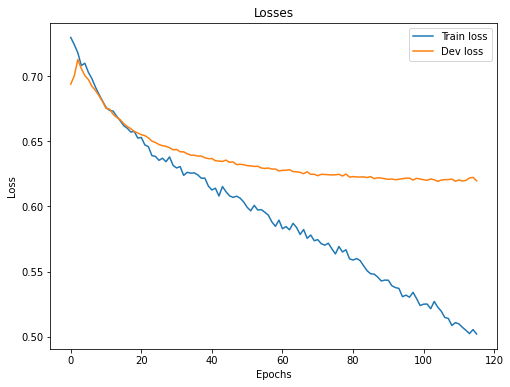

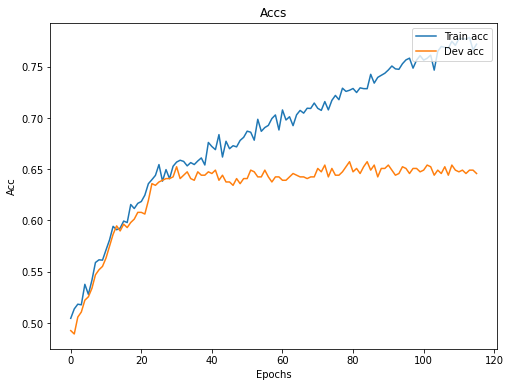

In [ ]:
def plot_logs(logs: dict):
    # define the figure
    plt.figure(figsize=(8,6))

    # define the two sequences that we want to show
    plt.plot(list(range(len(logs['train']))), logs['train'], label='Train loss')
    plt.plot(list(range(len(logs['dev']))), logs['dev'], label='Dev loss')
    
    # set title and axis name
    plt.title("Losses")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc="upper right")

    plt.show()

    # as before but for the accs
    plt.figure(figsize=(8,6))
    plt.plot(list(range(len(logs['train_accs']))), logs['train_accs'], label='Train acc')
    plt.plot(list(range(len(logs['dev_accs']))), logs['dev_accs'], label='Dev acc')
    
    plt.title("Accs")
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(loc="upper right")

    plt.show()

plot_logs(scores)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from matplotlib import pyplot
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

@torch.no_grad()
def plots(
    model: nn.Module,
    dataloader: DataLoader,
):
    accs = []
    preds = torch.tensor([])
    gt = torch.tensor([])
    size = 0
    for x, y in dataloader:
        # get the number of elements in the batch (it is not constant since the 
        # number of examples is not a multiple of BATCH_SIZE, so the last batch
        # will be smaller)
        size += len(y)
        outputs = model(x[0], x[1], y.float())
        preds = torch.hstack((preds, outputs["pred"]))
        gt = torch.hstack((gt, y))
        accs.append(outputs["correct"])

    # get mean acc and mean loss
    mean_acc = sum(accs)/size
    
    # confusion matrix
    classes = ["True", "False"]
    cf_matrix = confusion_matrix(gt.cpu().numpy(), torch.round(preds).cpu().numpy())
    df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
    plt.savefig('output.png')
    plt.show()

    print()

    # roc curve and score
    roc_score = roc_auc_score(gt.cpu().numpy(), preds.cpu().numpy())
    fpr, tpr, _ = roc_curve(gt.cpu().numpy(), preds.cpu().numpy())

    # plot the roc curve for the model
    pyplot.plot(fpr, tpr, marker='.', label='ROC AUC=%.3f' % (roc_score))
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    # show the plot
    pyplot.show()

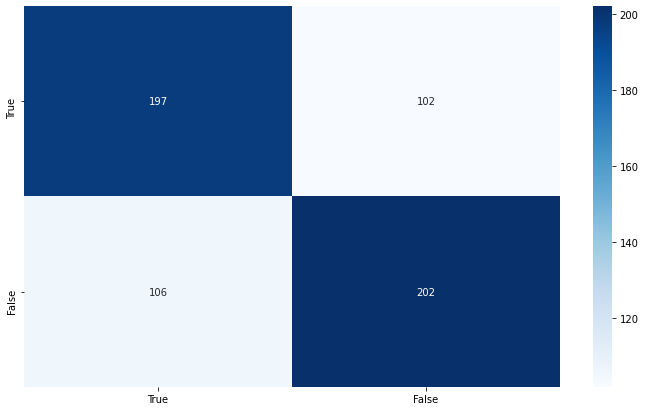

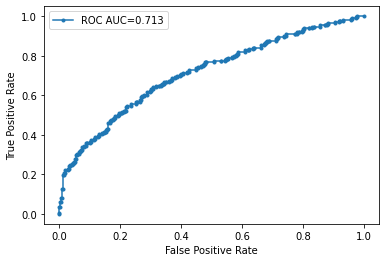

In [ ]:
model = Classifier(EMBEDDING_DIMENSION, n_hidden1=512, n_hidden2=256, dropout=0.5)
model.load_state_dict(torch.load(f"{FILE_NAME}.pt"))
model.eval()

plots(model, test_dataloader)